In [38]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import kmeans_plusplus, KMeans, SpectralClustering
import numpy as np
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from collections import Counter, defaultdict
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

In [39]:
df = pd.read_csv("DataExtracted/ElyoyaDataV2.csv")
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


Now that the data is collected from the riot API, I will start by seeing if there are any irregularities in the data.

Here the value_counts() function will be used because besides giving the information on how many player positions were collected in each match, it gives information on the games that were remaked and therefore will be removed. 

In [40]:
pd.set_option("display.max_rows", None)

df["gameId"].value_counts()

EUW1_6155602476    42
EUW1_6156430957    42
EUW1_6154372504    40
EUW1_6156848197    36
EUW1_6160920662    36
EUW1_6162595161    35
EUW1_6154165838    35
EUW1_6156713548    35
EUW1_6160614714    35
EUW1_6169361919    34
EUW1_6166201683    34
EUW1_6160122620    33
EUW1_6151765282    33
EUW1_6167017540    32
EUW1_6166266685    32
EUW1_6164815806    32
EUW1_6174116009    31
EUW1_6156559340    31
EUW1_6166357478    31
EUW1_6162519044    31
EUW1_6165754722    31
EUW1_6169720779    30
EUW1_6165735683    30
EUW1_6154019544    30
EUW1_6155233283    30
EUW1_6155459687    30
EUW1_6161351421    30
EUW1_6161484250    30
EUW1_6176366691    30
EUW1_6154082054    29
EUW1_6163819437    29
EUW1_6156652620    29
EUW1_6163695569    29
EUW1_6161274781    28
EUW1_6174897746    28
EUW1_6163920728    28
EUW1_6160146060    28
EUW1_6169332619    28
EUW1_6173376101    27
EUW1_6156508218    26
EUW1_6161529208    26
EUW1_6151839599    26
EUW1_6163787785    26
EUW1_6169961548    26
EUW1_6175455388    25
EUW1_61544

In [41]:
pd.set_option("display.max_rows", 10)

Looking at the number of player positions in each match, two games stood out for having less than 10 positions. Since the position of the player is collected every minute, this means that these two games have less than 10 minutes, and therefore means that the games did not happen (one team had a player that wasn't playing, which means that this team could give up the game)

With this being said, here EUW1_6166180735 and EUW1_6166247020 will be removed from the data frame.

In [42]:
df.drop(df[df['gameId'] == "EUW1_6166247020"].index, inplace = True)
df.drop(df[df['gameId'] == "EUW1_6166180735"].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
0,EUW1_6176366691,0.000000,557,345,Blue,True
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
...,...,...,...,...,...,...
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False
2009,EUW1_6151765282,31.008533,12258,8480,Red,False


---

In [43]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i,c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = np.array(["blueviolet", "yellow", "lime", "crimson"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

In [44]:
def clustering(df, scores = 0, bb = 0, bt = 0, rb = 0, rt = 0):
    scaler = StandardScaler()
    centroids = np.array([[8250, 4250], [4000, 8750],[12000, 7500], [7750, 12000]])
    centroids_scaled = scaler.fit_transform(centroids)
    nc = df.shape[1]
    df_array = df.values
    X2 = df_array[:, 2:4]
    X = df_array[:, 2:4]
    X_scaled = scaler.fit_transform(X)
    kmedoids = KMedoids(n_clusters=4, init= "k-medoids++",random_state=0).fit(X_scaled)
    label = kmedoids.fit_predict(X_scaled)

    #---------------
    #plot clusters
    #centroids2 = kmedoids.cluster_centers_
    u_labels = np.unique(label)
    img = plt.imread("map11.png")
    fig, ax = plt.subplots()
    ax.imshow(img, extent=[0, 16000, 0, 16000])
    
    #plotting the results:
    
    for i in u_labels:
        ax.scatter(X2[label == i , 0] , X2[label == i , 1] , label = i, color = np.array(["blueviolet", "yellow", "lime", "crimson"])[i])
    ax.legend(frameon = True)
    plt.grid(visible=None)
    plt.show()
    if(scores != 0):
        scores.append(silhouette_score(X_scaled, kmedoids.labels_))

    if(bb != 0):
        bb.append(Counter(kmedoids.labels_).get(0))
        bt.append(Counter(kmedoids.labels_).get(1))
        rb.append(Counter(kmedoids.labels_).get(2))
        rt.append(Counter(kmedoids.labels_).get(3))
    drawSillouette(X_scaled, kmedoids.labels_, "kmeans (K=4)")

    print("Kmeans silhouette_score", silhouette_score(X_scaled, kmedoids.labels_))
    print("Locations in cluster 0: {}\nLocations in cluster 1: {}\nLocations in cluster 2: {}\nLocations in cluster 3: {}\n".format(Counter(kmedoids.labels_).get(0),Counter(kmedoids.labels_).get(1),Counter(kmedoids.labels_).get(2),Counter(kmedoids.labels_).get(3)))
    print("--------------------------------------------------------------------------------------")
    #blueviolet - blue team's bot jungle
    #yellow - blue team's top jungle
    #lime - red team's bot jungle
    #crimson - red team's top jungle

In [45]:
df.drop(df[(df['coordinate_x'] <= 6000) & (df["coordinate_y"] <= 6000)].index, inplace = True)
df.drop(df[(df['coordinate_x'] >= 10500) & (df["coordinate_y"] >= 10500)].index, inplace = True)
df

,gameId,timestamp,coordinate_x,coordinate_y,team,won
1,EUW1_6176366691,1.000250,5633,9332,Blue,True
2,EUW1_6176366691,2.000750,8149,2265,Blue,True
3,EUW1_6176366691,3.001350,11532,4753,Blue,True
4,EUW1_6176366691,4.001617,11454,3261,Blue,True
5,EUW1_6176366691,5.001633,1232,13514,Blue,True
...,...,...,...,...,...,...
2005,EUW1_6151765282,27.007400,7572,12304,Red,False
2006,EUW1_6151765282,28.007417,10665,10235,Red,False
2007,EUW1_6151765282,29.007850,9714,5255,Red,False
2008,EUW1_6151765282,30.007983,7293,10934,Red,False


In [46]:
redTeam_df = df.loc[df["team"] == "Red"]
print("Red Team Data Frame:\n{}".format(redTeam_df))
print("\nElyoya played {} matches on the red team.".format(redTeam_df["gameId"].nunique()))

Red Team Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team    won
31    EUW1_6176325099   1.000250          9667          7063  Red  False
32    EUW1_6176325099   2.000350          8037          3520  Red  False
33    EUW1_6176325099   3.000583         11663          7725  Red  False
34    EUW1_6176325099   4.000900          7672          5223  Red  False
35    EUW1_6176325099   5.001633          3604         13800  Red  False
...               ...        ...           ...           ...  ...    ...
2005  EUW1_6151765282  27.007400          7572         12304  Red  False
2006  EUW1_6151765282  28.007417         10665         10235  Red  False
2007  EUW1_6151765282  29.007850          9714          5255  Red  False
2008  EUW1_6151765282  30.007983          7293         10934  Red  False
2009  EUW1_6151765282  31.008533         12258          8480  Red  False

[756 rows x 6 columns]

Elyoya played 33 matches on the red team.


In [47]:
redTeamWins_df = redTeam_df.loc[redTeam_df["won"] == True]
print("Red Team Winning Data Frame:\n{}".format(redTeamWins_df))

print("\nElyoya won {} matches on the red team.".format(redTeamWins_df["gameId"].nunique()))

Red Team Winning Data Frame:
               gameId  timestamp  coordinate_x  coordinate_y team   won
160   EUW1_6173376101   1.000200          7269          9759  Red  True
161   EUW1_6173376101   2.000483          7219         12424  Red  True
162   EUW1_6173376101   3.001183         11854          6708  Red  True
163   EUW1_6173376101   4.001733         10439         13946  Red  True
164   EUW1_6173376101   5.002283          3693          6591  Red  True
...               ...        ...           ...           ...  ...   ...
1860  EUW1_6154165838  27.008967         10968          8450  Red  True
1861  EUW1_6154165838  28.009083          8532          4744  Red  True
1862  EUW1_6154165838  29.009500          7563          9749  Red  True
1865  EUW1_6154165838  32.010183          7520          7674  Red  True
1866  EUW1_6154165838  33.010350          9017          6192  Red  True

[387 rows x 6 columns]

Elyoya won 17 matches on the red team.


1: EUW1_6173376101 - Red team Victory
Number of points:  24


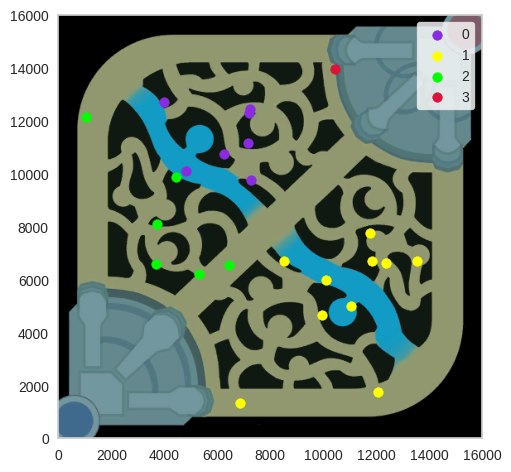

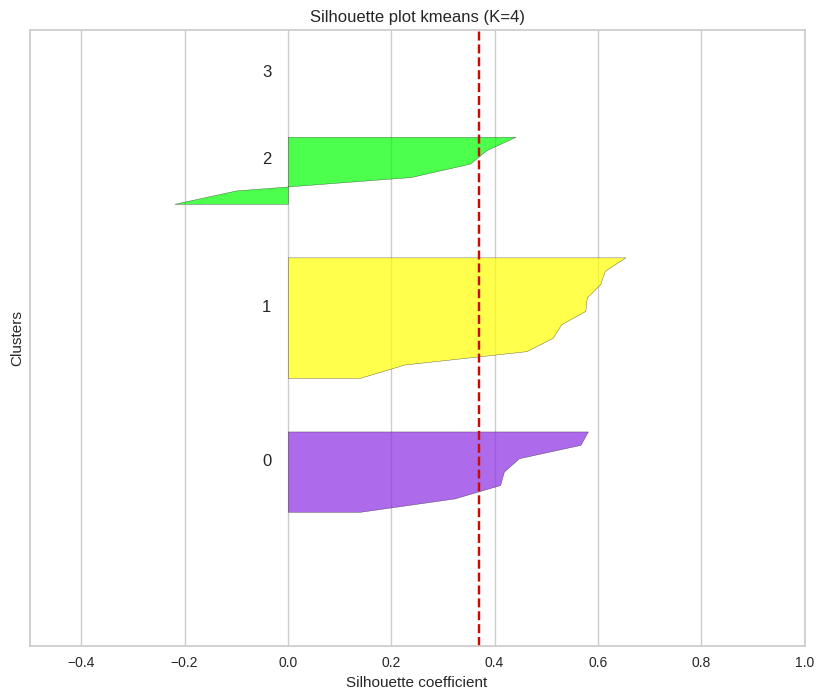

Kmeans silhouette_score 0.3697548591375788
Locations in cluster 0: 7
Locations in cluster 1: 10
Locations in cluster 2: 6
Locations in cluster 3: 1

--------------------------------------------------------------------------------------
2: EUW1_6170116709 - Red team Victory
Number of points:  18


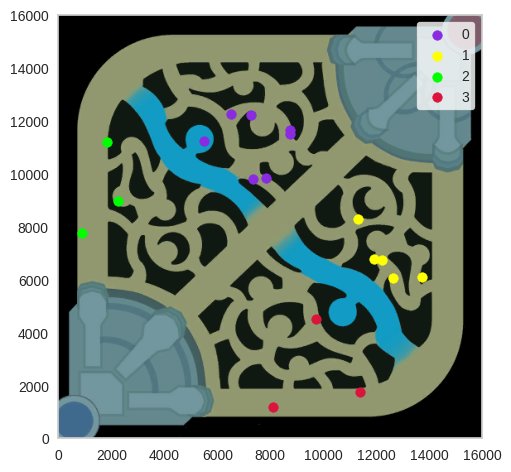

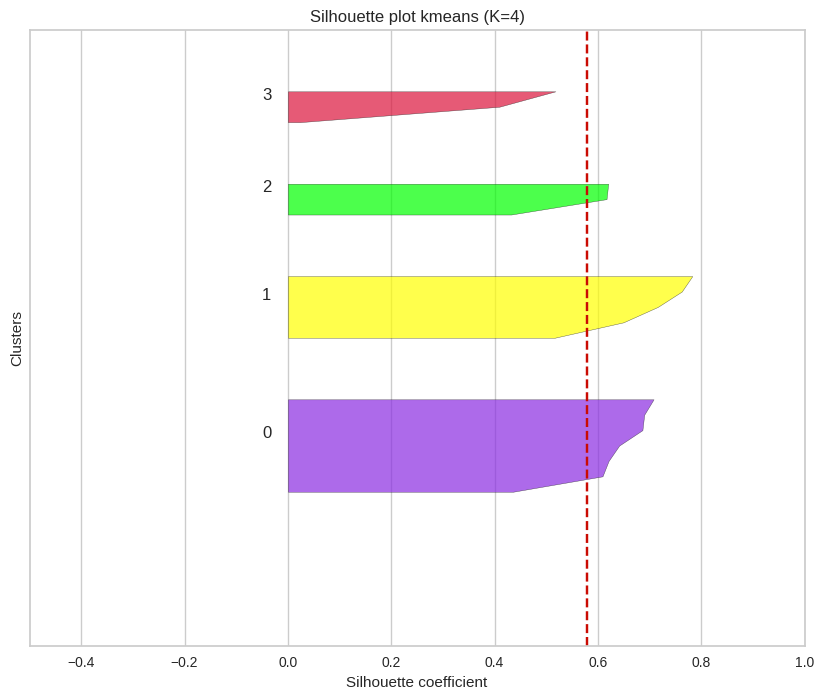

Kmeans silhouette_score 0.5797912245055153
Locations in cluster 0: 7
Locations in cluster 1: 5
Locations in cluster 2: 3
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
3: EUW1_6169961548 - Red team Victory
Number of points:  18


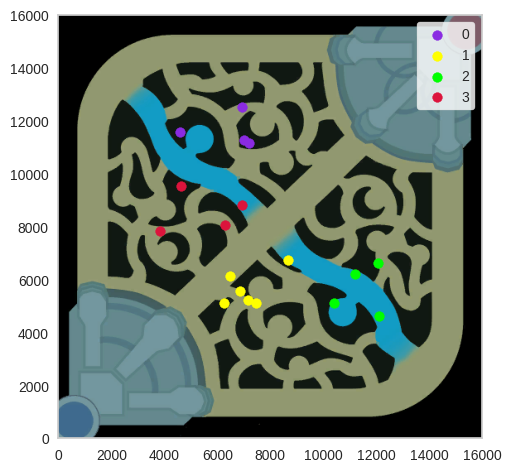

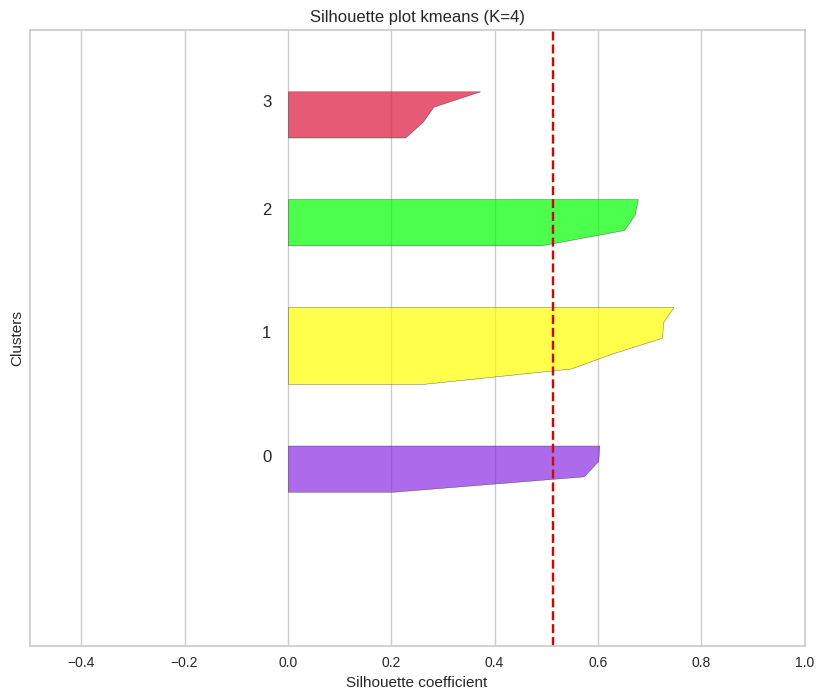

Kmeans silhouette_score 0.5136907101807515
Locations in cluster 0: 4
Locations in cluster 1: 6
Locations in cluster 2: 4
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
4: EUW1_6169756315 - Red team Victory
Number of points:  15


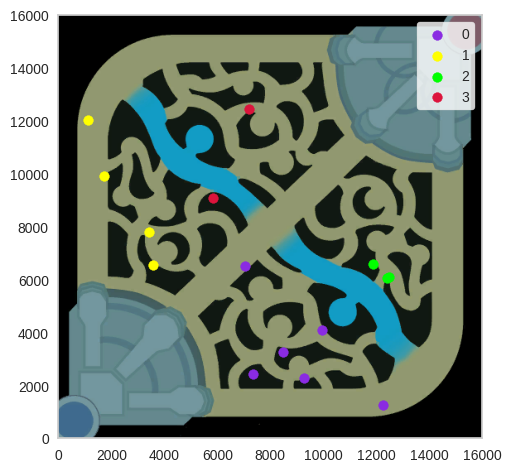

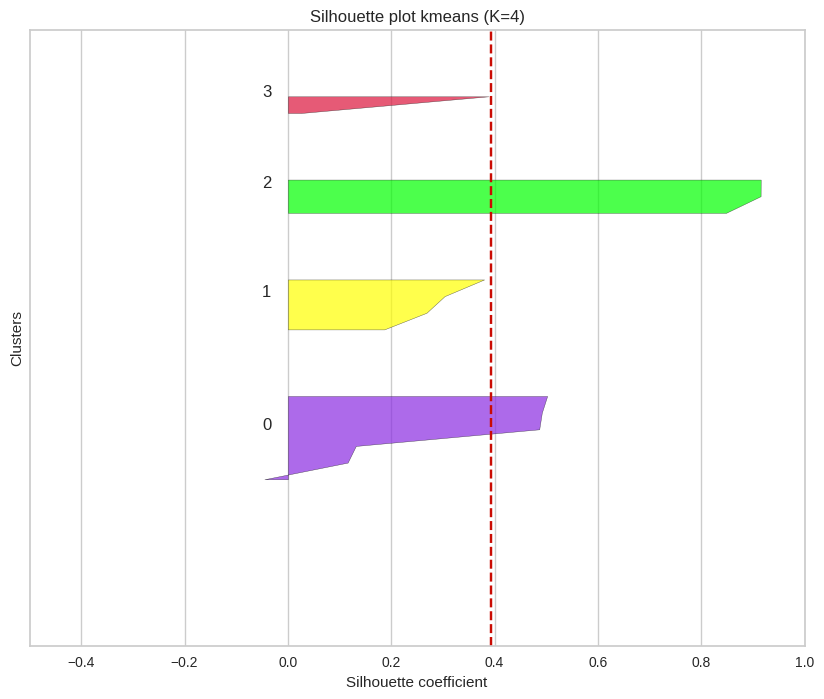

Kmeans silhouette_score 0.39406637956967383
Locations in cluster 0: 6
Locations in cluster 1: 4
Locations in cluster 2: 3
Locations in cluster 3: 2

--------------------------------------------------------------------------------------
5: EUW1_6169361919 - Red team Victory
Number of points:  23


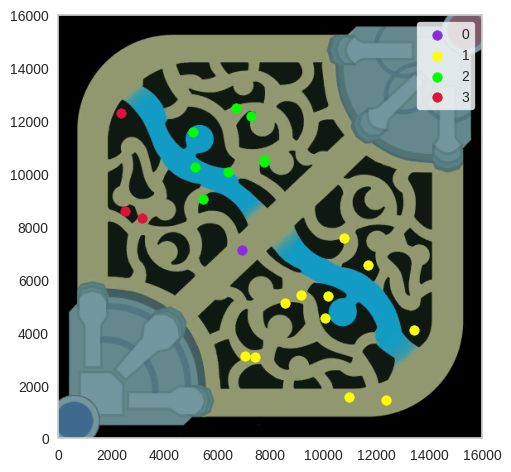

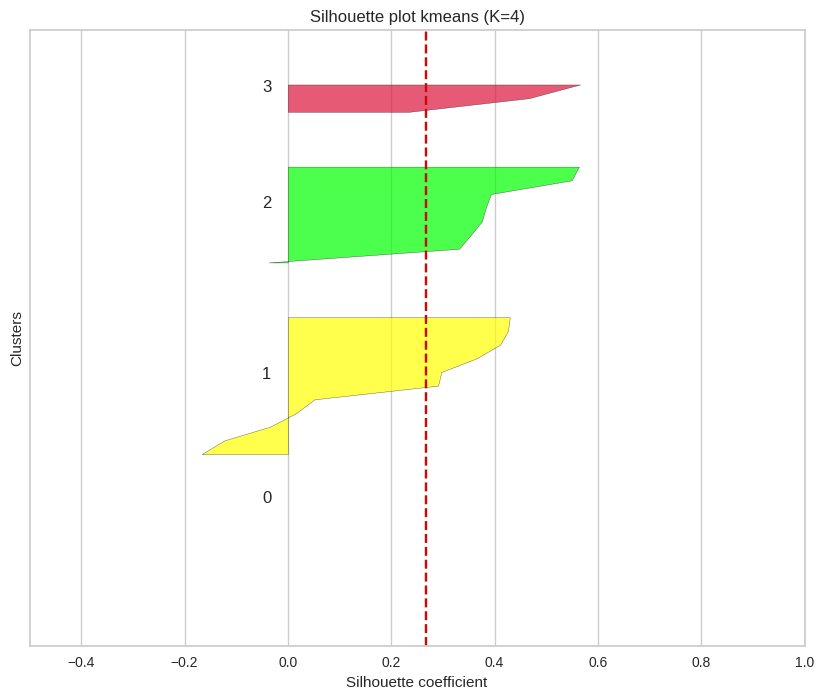

Kmeans silhouette_score 0.26695857915602156
Locations in cluster 0: 1
Locations in cluster 1: 11
Locations in cluster 2: 8
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
6: EUW1_6169332619 - Red team Victory
Number of points:  23


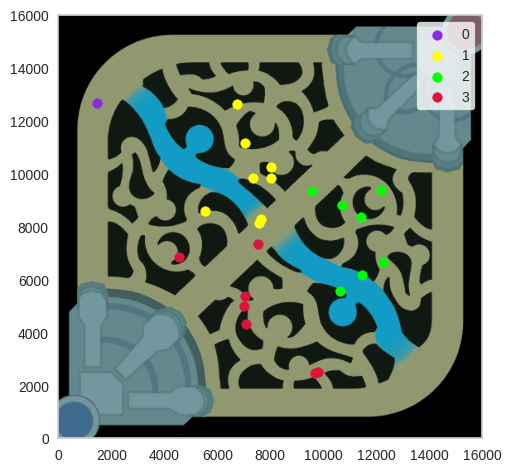

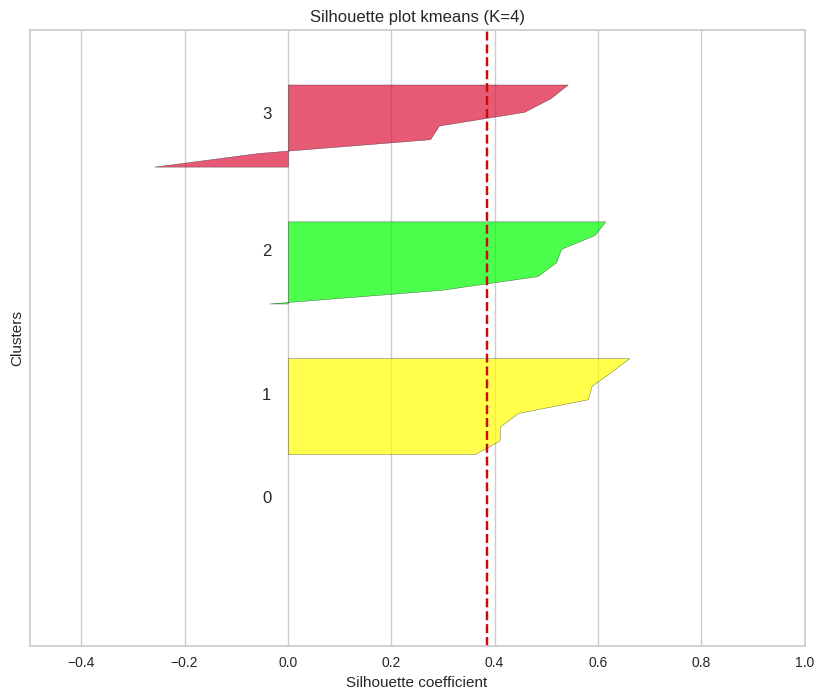

Kmeans silhouette_score 0.38441974107446386
Locations in cluster 0: 1
Locations in cluster 1: 8
Locations in cluster 2: 7
Locations in cluster 3: 7

--------------------------------------------------------------------------------------
7: EUW1_6166266685 - Red team Victory
Number of points:  26


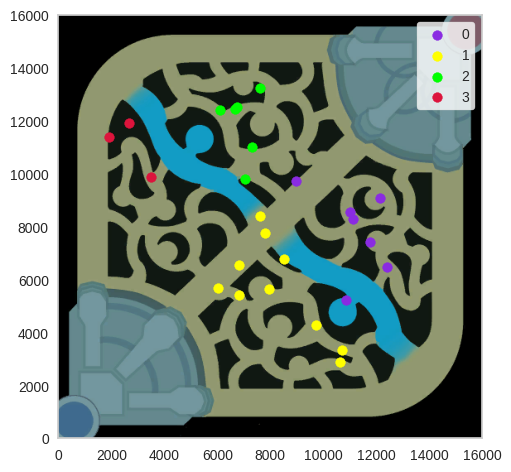

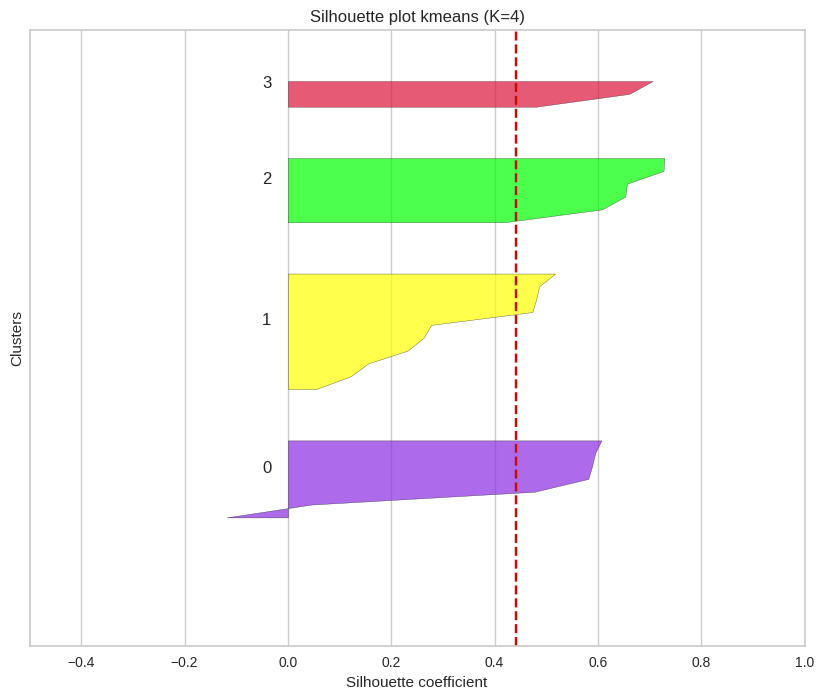

Kmeans silhouette_score 0.4413203459733169
Locations in cluster 0: 7
Locations in cluster 1: 10
Locations in cluster 2: 6
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
8: EUW1_6166201683 - Red team Victory
Number of points:  27


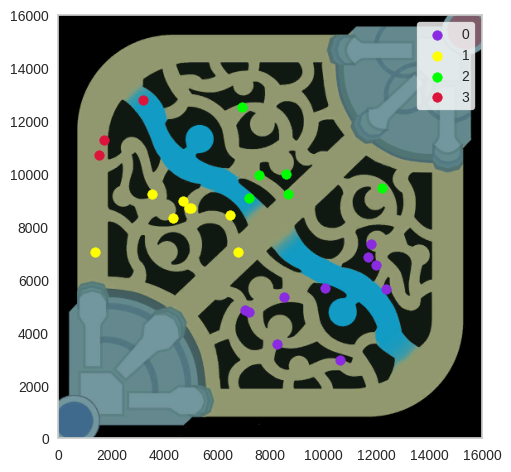

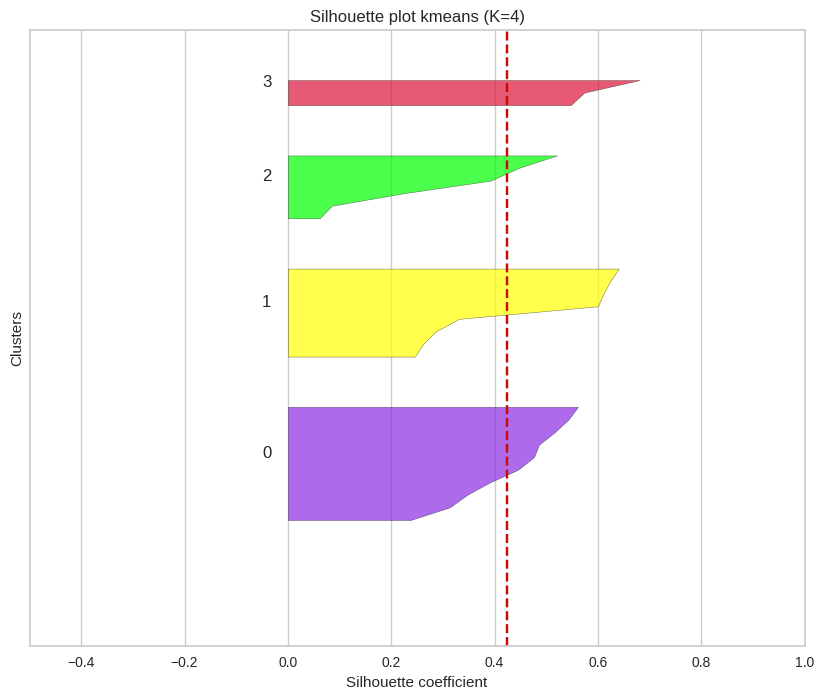

Kmeans silhouette_score 0.4241304224212801
Locations in cluster 0: 10
Locations in cluster 1: 8
Locations in cluster 2: 6
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
9: EUW1_6165754722 - Red team Victory
Number of points:  24


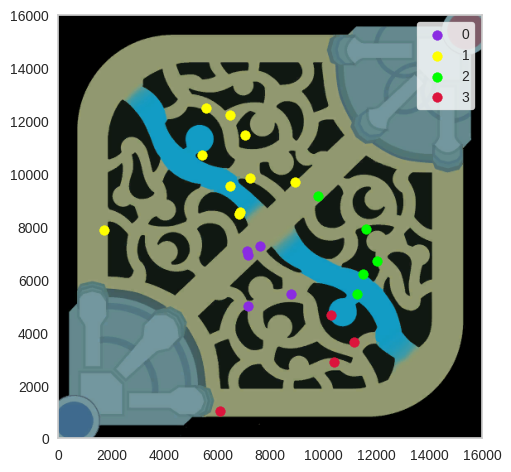

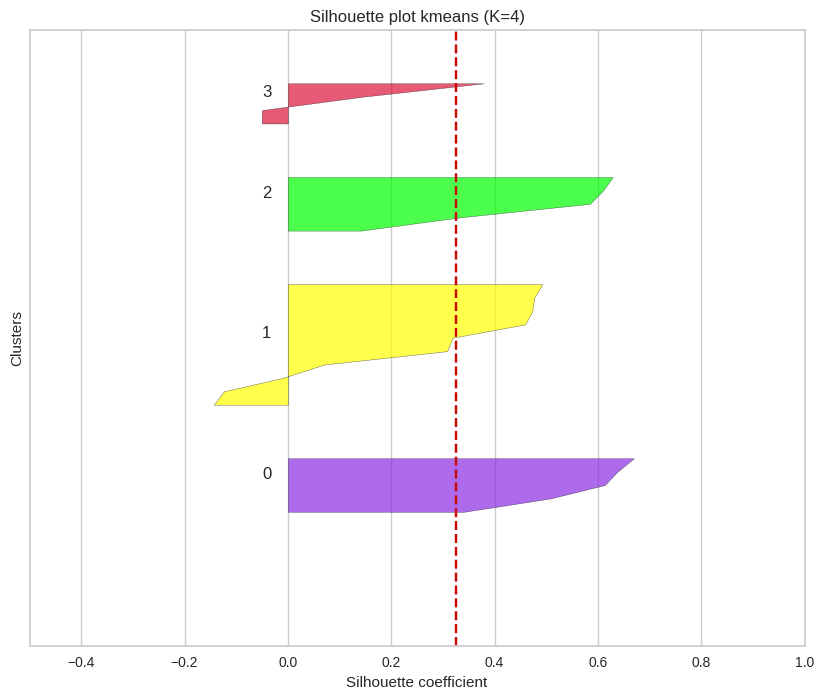

Kmeans silhouette_score 0.3256518533083174
Locations in cluster 0: 5
Locations in cluster 1: 10
Locations in cluster 2: 5
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
10: EUW1_6165735683 - Red team Victory
Number of points:  25


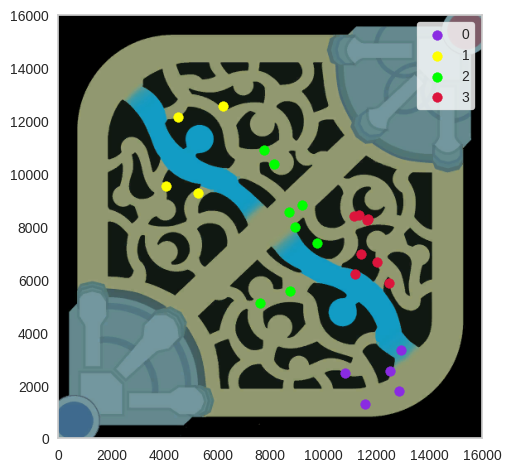

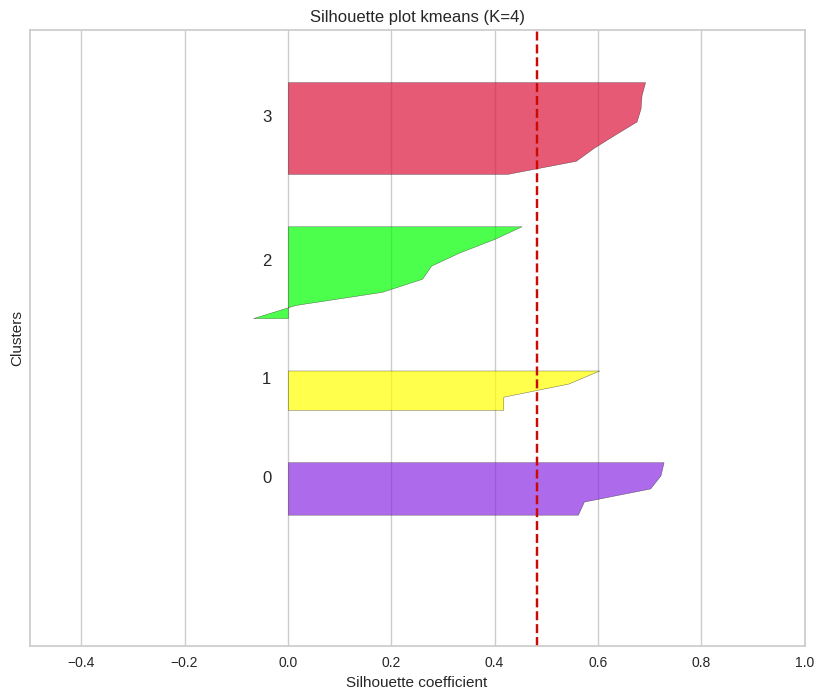

Kmeans silhouette_score 0.4820344375140851
Locations in cluster 0: 5
Locations in cluster 1: 4
Locations in cluster 2: 8
Locations in cluster 3: 8

--------------------------------------------------------------------------------------
11: EUW1_6163695569 - Red team Victory
Number of points:  25


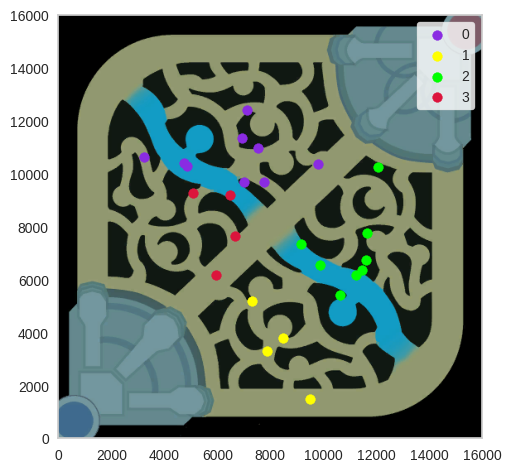

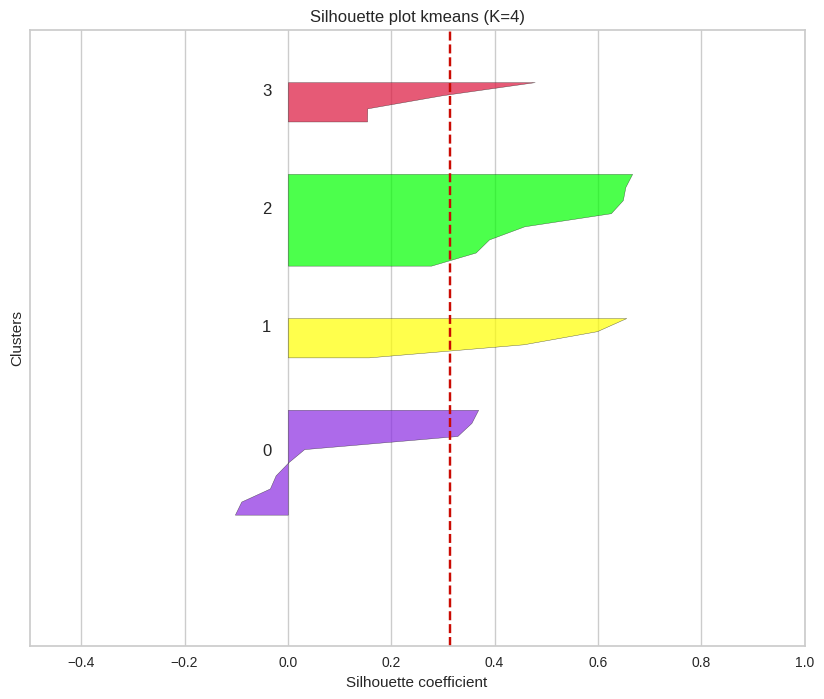

Kmeans silhouette_score 0.314456702091627
Locations in cluster 0: 9
Locations in cluster 1: 4
Locations in cluster 2: 8
Locations in cluster 3: 4

--------------------------------------------------------------------------------------
12: EUW1_6163629472 - Red team Victory
Number of points:  18


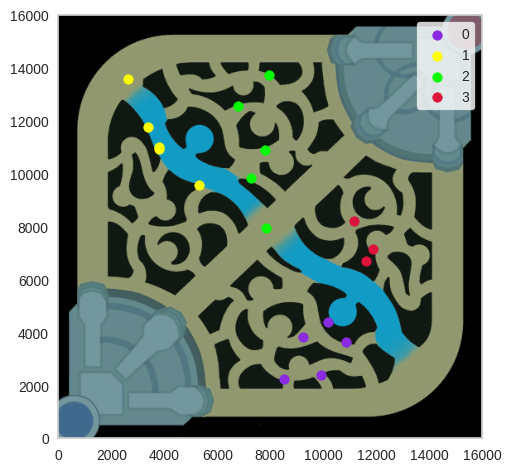

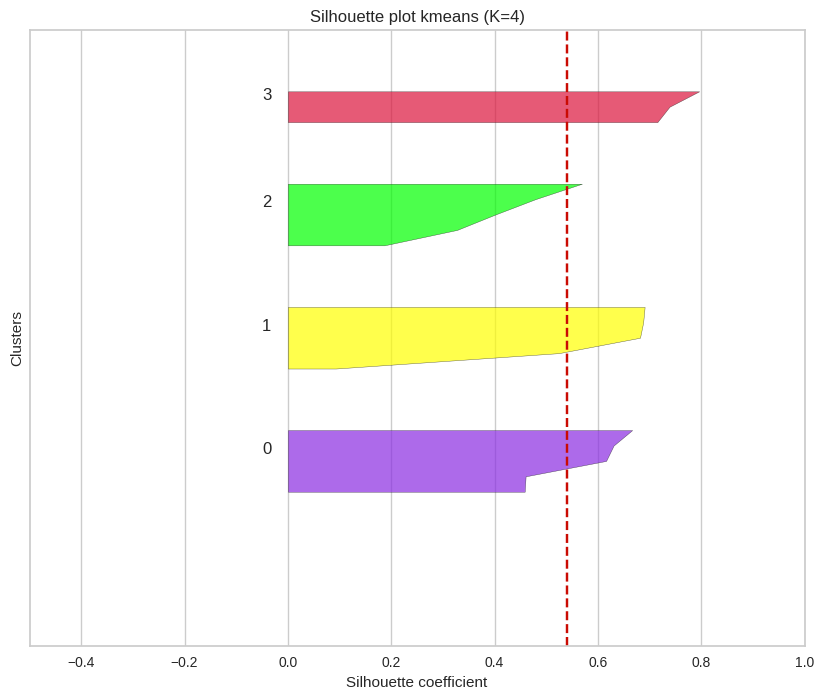

Kmeans silhouette_score 0.5400542582046807
Locations in cluster 0: 5
Locations in cluster 1: 5
Locations in cluster 2: 5
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
13: EUW1_6162595161 - Red team Victory
Number of points:  29


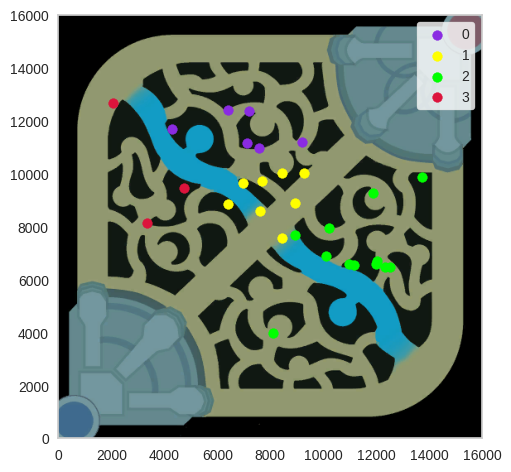

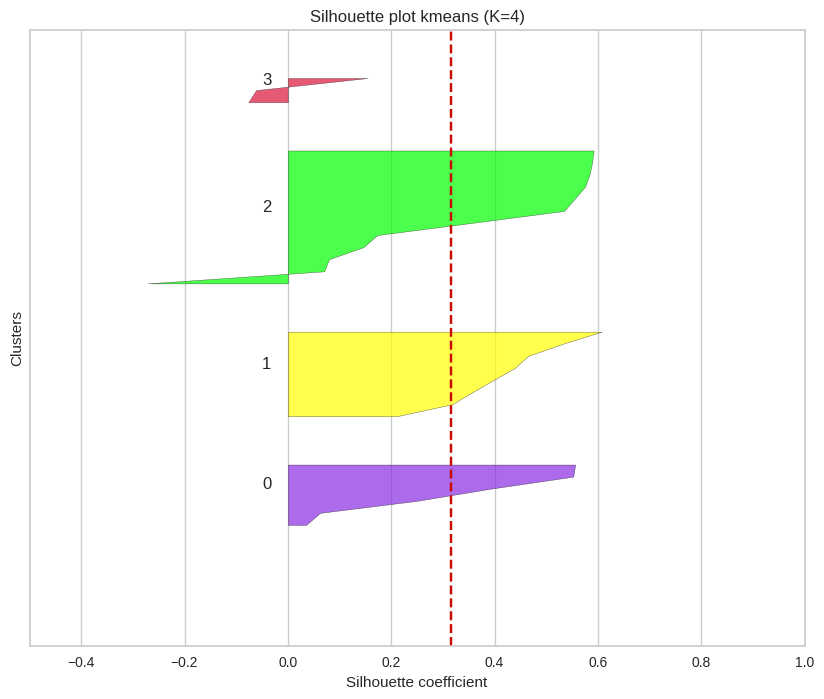

Kmeans silhouette_score 0.31631995013611564
Locations in cluster 0: 6
Locations in cluster 1: 8
Locations in cluster 2: 12
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
14: EUW1_6156713548 - Red team Victory
Number of points:  25


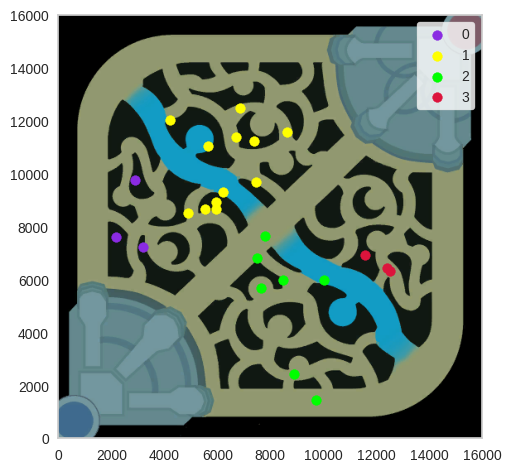

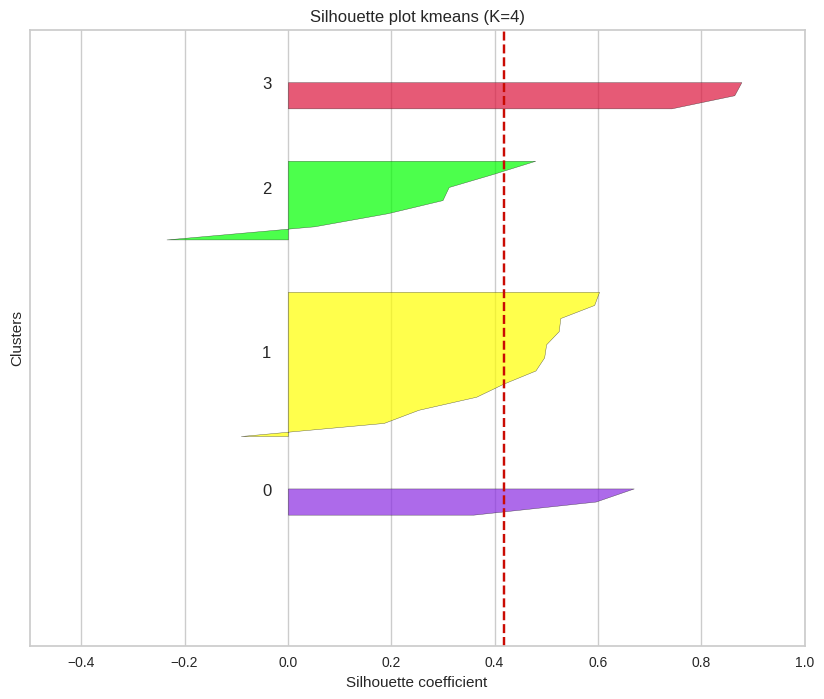

Kmeans silhouette_score 0.41818237772910455
Locations in cluster 0: 3
Locations in cluster 1: 12
Locations in cluster 2: 7
Locations in cluster 3: 3

--------------------------------------------------------------------------------------
15: EUW1_6155318816 - Red team Victory
Number of points:  22


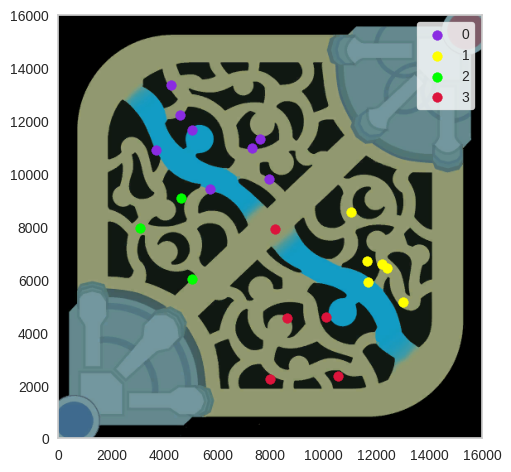

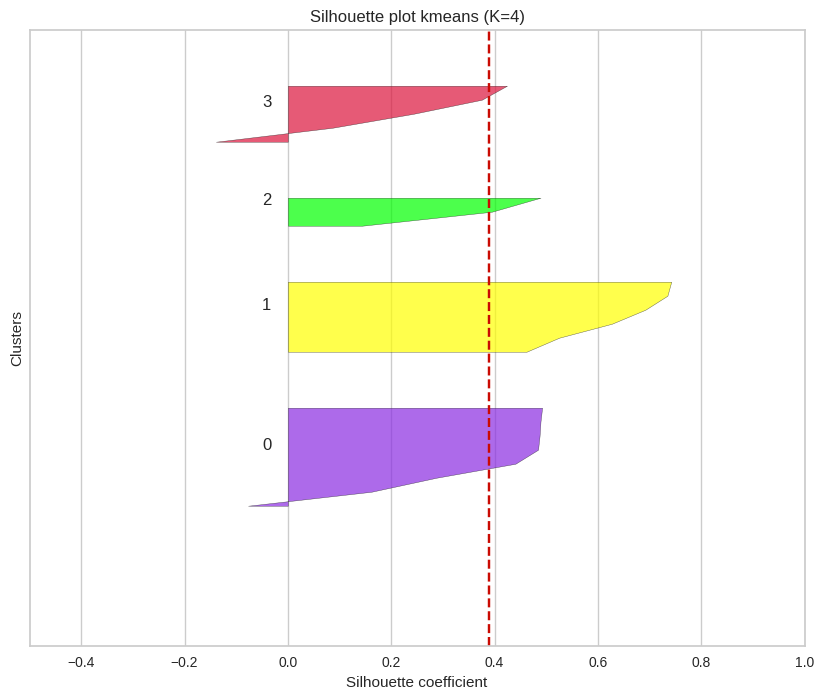

Kmeans silhouette_score 0.3892387634538583
Locations in cluster 0: 8
Locations in cluster 1: 6
Locations in cluster 2: 3
Locations in cluster 3: 5

--------------------------------------------------------------------------------------
16: EUW1_6154241292 - Red team Victory
Number of points:  18


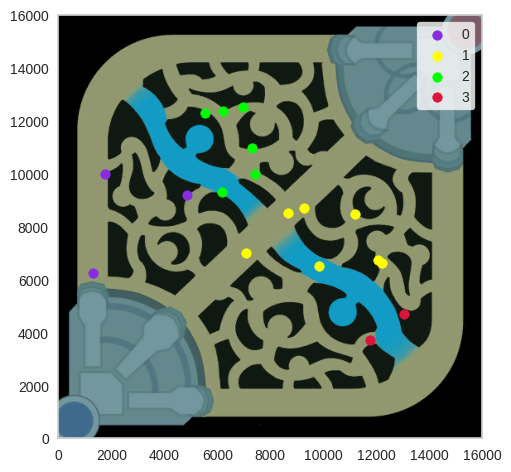

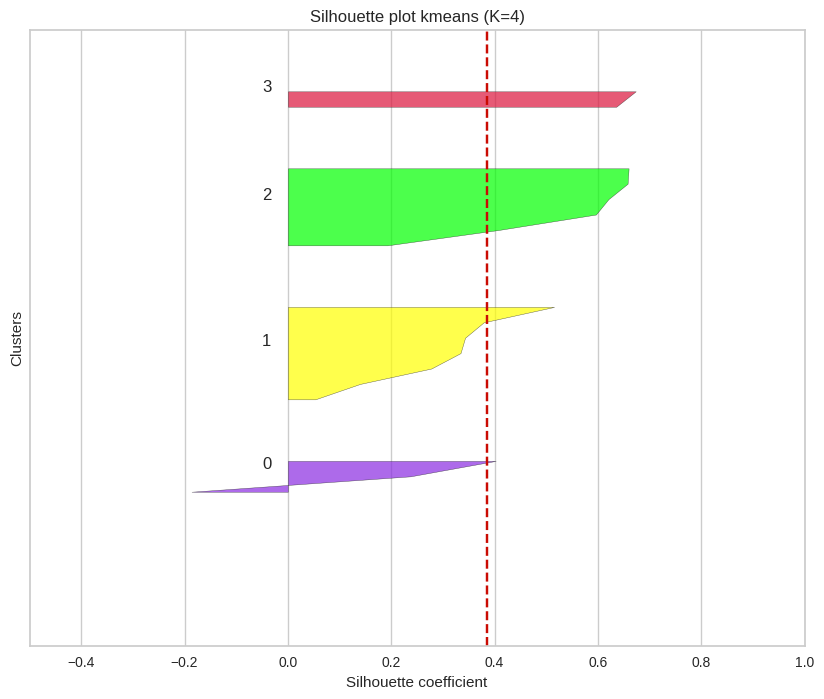

Kmeans silhouette_score 0.3854141664072555
Locations in cluster 0: 3
Locations in cluster 1: 7
Locations in cluster 2: 6
Locations in cluster 3: 2

--------------------------------------------------------------------------------------
17: EUW1_6154165838 - Red team Victory
Number of points:  27


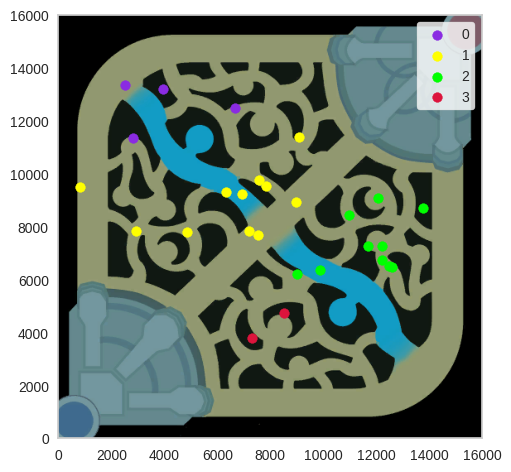

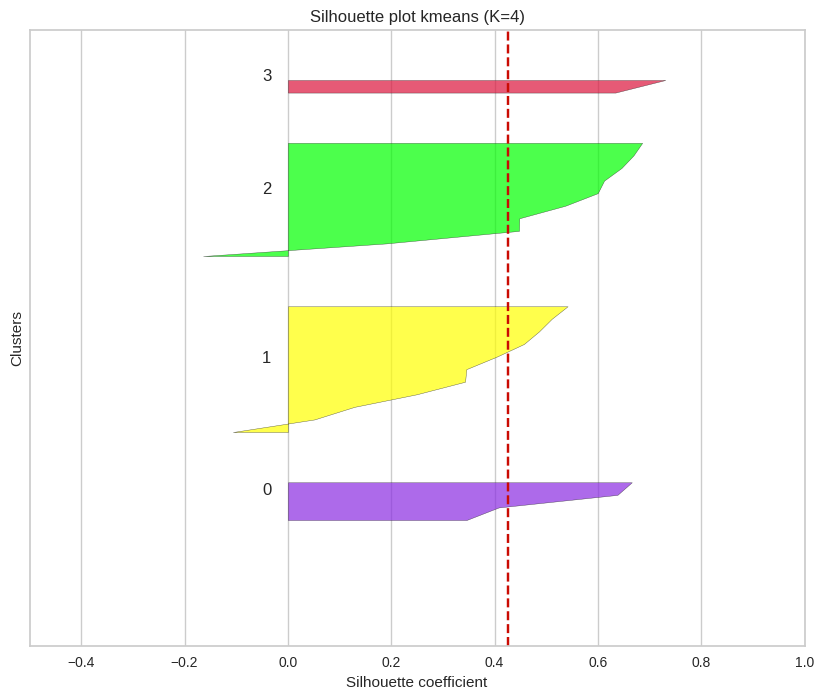

Kmeans silhouette_score 0.4259370600173024
Locations in cluster 0: 4
Locations in cluster 1: 11
Locations in cluster 2: 10
Locations in cluster 3: 2

--------------------------------------------------------------------------------------


In [48]:
n = 1
scores = []
npoints = []
bb = []
bt = []
rb = []
rt = []
for game in redTeamWins_df.gameId.unique():
    game_df = df.loc[df["gameId"] == game]
    print("{}: {} - {} team Victory".format(n, game, game_df["team"].unique()[0]))
    print("Number of points: ", game_df.shape[0])
    npoints.append(game_df.shape[0])
    clustering(game_df, scores, bb, bt, rb, rt)
    n += 1

In [49]:
mean = np.mean(np.array(scores))
avPoints = np.mean(np.array(npoints))
avBb = np.sum(np.array(bb))
avBt = np.sum(np.array(bt))
avRb = np.sum(np.array(rb))
avRt = np.sum(np.array(rt))
print("When Red team Wins:")
print(" - Average silhouette score: ", mean)
print(" - Average points: ", avPoints)
print(" - Average points on the blue team's bottom jungle: ", avBb)
print(" - Average points on the blue team's top jungle: ", avBt)
print(" - Average points on the red team's bottom jungle: ", avRb)
print(" - Average points on the red team's top jungle: ", avRt)

When Red team Wins:
 - Average silhouette score:  0.410083637110644
 - Average points:  22.764705882352942
 - Average points on the blue team's bottom jungle:  91
 - Average points on the blue team's top jungle:  129
 - Average points on the red team's bottom jungle:  107
 - Average points on the red team's top jungle:  60


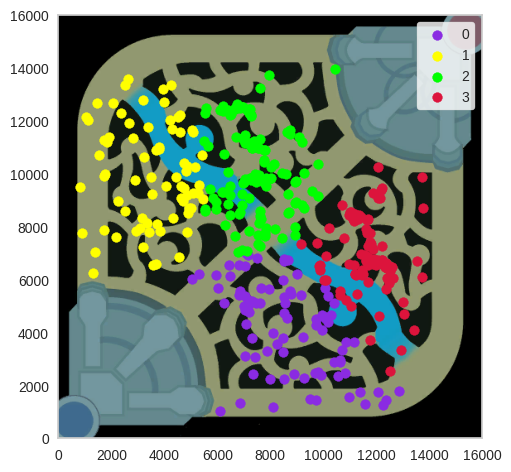

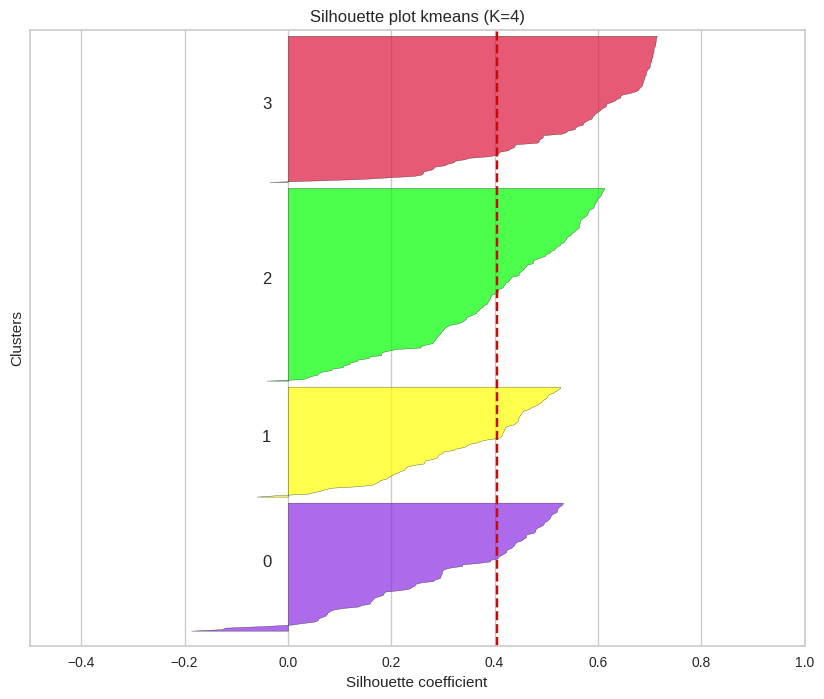

Kmeans silhouette_score 0.40459019742694907
Locations in cluster 0: 86
Locations in cluster 1: 74
Locations in cluster 2: 129
Locations in cluster 3: 98

--------------------------------------------------------------------------------------


In [50]:
clustering(redTeamWins_df)